In [64]:
import xarray as xr
from importlib import reload
import numpy as np
import pandas as pd
import os

import xarray_class_accessors as xca
import signal_to_noise as sn

In [65]:
ROOT_DIR = '/g/data/w40/ab2313/longrunmip'

In [66]:
control_chunks = {'lat':48/2,'lon':96/2,'time':-1}

In [4]:
control = xr.open_dataset(f'{ROOT_DIR}/tas_mon_CCSM3_control_1530.nc',
                             use_cftime = True, chunks = control_chunks).tas

In [5]:
# Applying correctinos to the data
control = control.correct_data.apply_corrections()

Testing months in each year...
- First year removed: 11 month(s) in year 1
- Last year removed:  1 month(s) in year 1531

Data Correction complete - all years now have 12 months


In [7]:
control

<xarray.DataArray 'tas' (time: 18348, lat: 48, lon: 96)>
dask.array<where, shape=(18348, 48, 96), dtype=float32, chunksize=(18348, 24, 48), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0002-01-01 00:00:00 ... 1530-12-01 00:00:00
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
Attributes:
    units:        K
    long_name:    Reference height temperature
    cell_method:  time: mean

In [8]:
climatology = control.clima.climatology(start = control.time.dt.year.values[0], 
                                          end = control.time.dt.year.values[-1])
climatology

<xarray.DataArray 'tas' (lat: 48, lon: 96)>
dask.array<mean_agg-aggregate, shape=(48, 96), dtype=float32, chunksize=(24, 48), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2

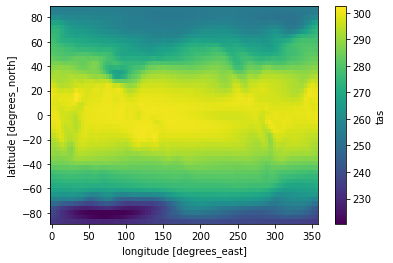

In [9]:
climatology.plot()

In [10]:
# Calulating the anomalies from the climatology that is based upon itself.
control_anomalies = control.clima.anomalies(start = control.time.dt.year.values[0], 
                                          end = control.time.dt.year.values[-1])

In [11]:
# Getting the space mean
control_anomalies_smean = control_anomalies.clima.space_mean()

In [12]:
control_anomalies_smean 

<xarray.DataArray 'tas' (time: 1529)>
dask.array<truediv, shape=(1529,), dtype=float64, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0002-12-31 00:00:00 ... 1530-12-31 00:00:00

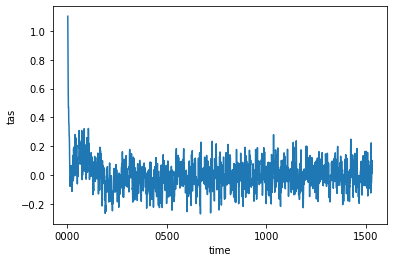

In [13]:
control_anomalies_smean.plot()

# Signal to Noise

In [14]:
loess_control = control_anomalies_smean.sn.loess_grid()

In [15]:
loess_control

<xarray.DataArray 'tas' (time: 1529)>
dask.array<sub, shape=(1529,), dtype=float64, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0002-12-31 00:00:00 ... 1530-12-31 00:00:00

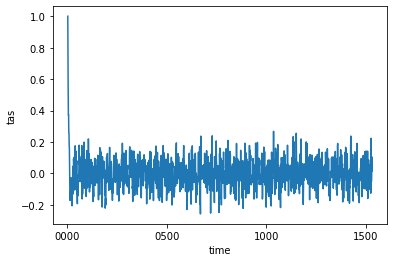

In [16]:
loess_control.plot()

In [17]:
%%time
loess_control_grid = control_anomalies.sn.loess_grid()

CPU times: user 21min 38s, sys: 3.23 s, total: 21min 41s
Wall time: 21min 53s


In [45]:
# Adding some attributes
now = pd.Timestamp.now().strftime(format = '%Y/%m/%d')
loess_control_grid.attrs = {'history': f'Modified by Alex Borowiak on {now}','stats': 'loess detrended data'}

In [56]:
loess_control_grid

<xarray.DataArray 'tas' (time: 1529, lat: 48, lon: 96)>
array([[[ 1.51552159,  1.53004222,  1.54270041, ...,  1.45277938,
          1.47744946,  1.49524882],
        [ 1.44627603,  1.43363121,  1.40926705, ...,  1.32976175,
          1.39477899,  1.42375434],
        [ 0.90759791,  0.81964563,  0.70729722, ...,  0.99014527,
          1.02832343,  1.00502307],
        ...,
        [ 8.44314499,  9.19764642,  9.39267518, ...,  5.79290652,
          6.46590981,  7.29136474],
        [ 5.69058779,  5.89161996,  6.06804604, ...,  4.9461422 ,
          5.18026583,  5.42073982],
        [ 4.11823597,  4.17196952,  4.22035304, ...,  4.04062812,
          4.07077184,  4.09491277]],

       [[ 1.02182779,  1.04741224,  1.04408969, ...,  0.95585741,
          0.98836017,  1.0014008 ],
        [ 1.66842822,  1.70011902,  1.70439759, ...,  1.499121  ,
          1.5725507 ,  1.63506289],
        [ 1.49536355,  1.58624802,  1.6602949 , ...,  1.24993281,
          1.32842345,  1.41415292],
...
        [-0.18805023, -0.32203329, -0.55066557, ..., -1.00258436,
         -0.93026646, -0.46914717],
        [-1.1748242 , -1.17570822, -1.21760886, ..., -1.26130774,
         -1.30510479, -1.2843127 ],
        [-0.92111953, -0.93378995, -0.93368645, ..., -0.84852409,
         -0.88007208, -0.90569285]],

       [[-0.56297232, -0.60426397, -0.64878292, ..., -0.42001686,
         -0.47651082, -0.5176318 ],
        [-1.72607977, -1.88733435, -2.04292107, ..., -1.27312358,
         -1.42738883, -1.57588316],
        [-1.4711752 , -1.70707032, -1.95247325, ..., -1.05643635,
         -1.15599419, -1.28036469],
        ...,
        [-2.35065533, -2.63496406, -2.69718611, ..., -1.41259828,
         -1.54272182, -1.89109461],
        [-2.42808893, -2.45341586, -2.42101136, ..., -2.17198987,
         -2.29381381, -2.38004052],
        [-2.24196131, -2.23022401, -2.21094747, ..., -2.24671063,
         -2.24850637, -2.24747532]]])
Coordinates:
  * time     (time) object 0002-12-31 00:00:00 ... 1530-12-31 00:00:00
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
Attributes:
    history:  Modified by Alex Borowiak on 2021/08/03
    stats:    loess detrended data

In [58]:
loess_control_grid.to_netcdf(os.path.join(ROOT_DIR,'loess', 'tas_mon_CCSM3_control_1530_loess.nc'))

# Streamlined
No step through. Just the important steps.

In [135]:
quadco2 = xr.open_dataset(f'{ROOT_DIR}/tas_mon_CCSM3_abrupt4x_2120.nc',
                             use_cftime = True, chunks = {'lat':100,'lon':100}).tas

# Applying correctinos to the data.
quadco2 = quadco2.correct_data.apply_corrections()

Testing months in each year...
Inital time length: 25440
- First year removed: 11 month(s) in year 1
- Last year removed:  1 month(s) in year 2121
- Incorrect year detected and time overridden

Data Correction complete - all years now have 12 months
Final time length: 25428


In [136]:
quadco2_yearmean = quadco2.resample(time = 'Y').mean(dim = 'time')

In [137]:
quadco2_anom = quadco2_yearmean.clima.anomalies(start = control.time.dt.year.values[0], 
                                          end = control.time.dt.year.values[-1],
                            historical = control)

Using historical dataset


In [138]:
quadco2_anom_smean = quadco2_anom.clima.space_mean()

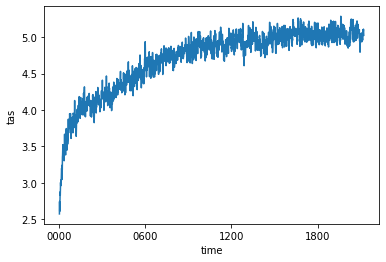

In [140]:
quadco2_anom_smean.plot()

In [142]:
%%time
loess_quadco2 = quadco2_anom.sn.loess_grid()

CPU times: user 29min 35s, sys: 4 s, total: 29min 39s
Wall time: 29min 50s


In [143]:
# Adding some attributes
now = pd.Timestamp.now().strftime(format = '%Y/%m/%d')
loess_quadco2.attrs = {'history': f'Modified by Alex Borowiak on {now}','stats': 'loess detrended data'}

In [144]:
loess_quadco2.to_netcdf(os.path.join(ROOT_DIR, 'loess', 'tas_mon_CCSM3_abrupt4x_2120.nc'))